# Presentation
Runan Zhang(457929)

# 1.Our Goal

The goal of this project is to simulate the mid-price of a stock using a random walk model and compare the results with findings from the paper "High-frequency trading in a limit order book" by Marco Avellaneda and Sasha Stoikov. We aim to understand the behavior of stock prices in a high-frequency trading environment and validate our simulation model against the theoretical framework provided in the paper.

# 2.ChatGPT Use

-Clarifying the concepts and methodologies presented in the paper.

-Generating and refining the Python code for the random walk simulation.

-Providing explanations and comments for the code to enhance understanding.

-Assisting in the structuring and writing of the presentation content.

# 3.Set Up

-numpy for numerical operations and random number generation.

-matplotlib for plotting the simulation results.

-time for setting the random seed based on the current time.

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 4.Codes

## Step1---Ramdom Walk

### 1.Imports and Initialization:



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import time

### 2.Random Seed Initialization:



In [21]:
current_time = int(time.time())
np.random.seed(current_time)

### 3.Function Definition:

In [22]:
def simulate_mid_price(S0, sigma, T, dt):
    
    N = int(T / dt)  # Number of time steps
    W = np.random.normal(0, np.sqrt(dt), N)  # Brownian increments
    S = np.zeros(N)
    S[0] = S0
    
    for t in range(1, N):
        S[t] = S[t-1] + sigma * W[t-1]
        
    return S

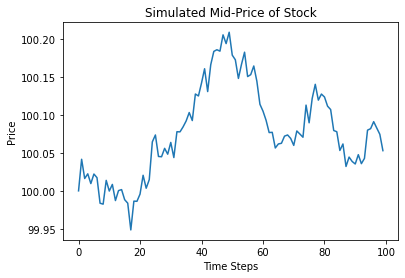

In [23]:
# Parameters
S0 = 100  # Initial stock price
sigma = 0.2  # Volatility
T = 1.0  # Total time period (e.g., 1 year)
dt = 0.01  # Time step (e.g., daily steps)

# Simulate mid-price
mid_price = simulate_mid_price(S0, sigma, T, dt)

# Plot the results
plt.plot(mid_price)
plt.title("Simulated Mid-Price of Stock")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.show()


# Step2--Strategy Implement

We will have functions to retrieve prices for our proposed 'inventory' strategy.

Here're inserting two classes InventoryStrategy (market making strategy that was proposed in the paper) and BenchmarkStrategy (the simple strategy they compare to). 

Both take a random walk (list of prices) and some parameters during creation and return PnL from run_strategy() 
function. 

There are some additional elements to exactly fit what was in the paper but that’s the general idea.

## --InventoryStrategy

In [24]:
class InventoryStrategy:
    def __init__(self, prices, sigma=2, theta=0.1, k=1.5, A=140, dt=0.005, T=1) -> None:
        self.prices = prices # prices
        self.spreads = [] # here we will save spreads for use in benchmark strategy
        self.sigma = sigma # stock's volatility
        self.theta = theta # risk aversion parameter
        self.k = k # parameter for the arrival rate function
        self.A = A # parameter for the arrival rate function
        self.dt = dt # time resolution parameter
        self.T = T # terminal time
        self.inventory = 0 # current inventory
        self.pnl = 0 # current pnl

    def calculate_bid_ask(self, mid_price, t):
        # Calculate the reservation price
        reservation_price = mid_price - self.inventory * self.theta * self.sigma**2 * (self.T - t)
        
        # Calculate the optimal distances for bid and ask prices
        delta_b = self.sigma**2 * (self.T - t) + (2 / self.theta) * np.log(1 + self.theta / self.k)
        delta_a = self.sigma**2 * (self.T - t) + (2 / self.theta) * np.log(1 + self.theta / self.k)
        
        # Calculate bid and ask prices
        bid_price = reservation_price - delta_b
        ask_price = reservation_price + delta_a

        self.spreads.append(ask_price - bid_price)
        
        return bid_price, ask_price
    
    def update_inventory(self, mid_price, t):
        bid, ask = self.calculate_bid_ask(mid_price, t)

        lambda_b = self.A * np.exp(-self.k * (ask - mid_price))
        lambda_a = self.A * np.exp(-self.k * (mid_price - bid))
        
        if np.random.rand() < lambda_b * self.dt:
            self.inventory += 1
            self.pnl -= bid
        
        if np.random.rand() < lambda_a * self.dt:
            self.inventory -= 1
            self.pnl += ask

    def get_average_spread(self):
        return sum(self.spreads)/len(self.spreads)
    
    def run_strategy(self):
        t = 0
        for price in self.prices:
            self.update_inventory(price, t)
            t += self.dt

        self.pnl += self.inventory*self.prices[-1]

        return self.pnl
    
    def reset(self, prices=None):
        self.inventory = 0
        self.pnl = 0
        self.spreads = []
        if prices:
            self.prices = prices


## --BenchmarkStrategy

Benchmark strategy uses symmetric bid/ask spread where spread is the average spread of the 'inventory' strategy

In [25]:
class BenchmarkStrategy:
    def __init__(self, prices, spread, A=140, k=1.5, dt=0.005):
        self.prices = prices  # stock prices
        self.spread = spread  # spread to be used - in the paper it was avg spread of the other strategy
        self.inventory = 0
        self.pnl = 0
        self.A = A  
        self.k = k  
        self.dt = dt  
    
    # get bid and ask for a given moment
    def calculate_bid_ask(self, price):
        return price - self.spread / 2, price + self.spread / 2

    # update inventory for a given moment
    def update_inventory(self, bid, ask, price):
        
        # Simulate arrival of market orders
        lambda_b = self.A * np.exp(-self.k * (ask - price))
        lambda_a = self.A * np.exp(-self.k * (price - bid))
        
        if np.random.rand() < lambda_b * self.dt:
            self.inventory += 1
            self.pnl -= bid
        
        if np.random.rand() < lambda_a * self.dt:
            self.inventory -= 1
            self.pnl += ask

    # get pnl for a single simulation
    def run_strategy(self):
        for price in self.prices:
            bid, ask = self.calculate_bid_ask(price)
            self.update_inventory(bid, ask, price)

        self.pnl += self.inventory*self.prices[-1]

        return self.pnl
    
    # reset class between runs
    def reset(self, spread, prices=None):
        self.inventory = 0
        self.pnl = 0
        self.spread = spread
        if prices:
            self.prices = prices


    
    

# Step3-- Simulation

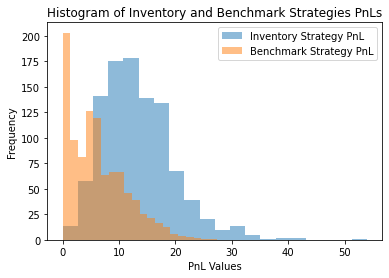

13.295216608859912


In [26]:
res_inv = []
res_bench = []

prices = simulate_mid_price(100, 2, 1, 0.005) 

for i in range(1000):
    inv = InventoryStrategy(prices=prices)
    res_inv.append(inv.run_strategy())
    bench = BenchmarkStrategy(prices=prices, spread=inv.get_average_spread())
    res_bench.append(bench.run_strategy())

num_bins = 20

# Plot histograms
plt.hist(res_inv, bins=num_bins, alpha=0.5, label='Inventory Strategy PnL')
plt.hist(res_bench, bins=num_bins, alpha=0.5, label='Benchmark Strategy PnL')

# Add labels and legend
plt.xlabel('PnL Values')
plt.ylabel('Frequency')
plt.title('Histogram of Inventory and Benchmark Strategies PnLs')
plt.legend(loc='upper right')

# Show plot
plt.show()

print(sum(res_inv)/len(res_inv))

# 5. Results